# 유럽축구데이터를 기반으로 주요 유럽축구 클럽들에 대한 UEFA Coefficient 예측.
* #### Small project in DSS-3 (김경수, 김용환, 전영호, 조일연)
![Image](./Resource/UEFA_Image.png)
___

## Why?
* 유럽리그의 데이터로 UEFA Champions league/Europa League 순위를 예측할 수 있을까?
* 경기력과 자본은 과연 성적과 직결될까?

## Goal
* 각 나라의 리그의 팀들의 데이터 **(input)** = > UEFA Champions league 순위예측 **(output)**

## How?
* 데이터 수집
    * 축구 관련 통계 사이트 중 대표적인 사이트인 Whoscored, Transfermarkt에서 각 리그 데이터를 추출   ***X***
         - 영국, 이탈리아, 스페인, 프랑스, 독일, 러시아, 네덜란드, 터키 
      ___ 
    * UEFA 공식홈페이지에서 UEFA rankings for club competitions(16/17) 순위를 추출 ***Y***
    * 각 리그의 시즌별 평균을 X 값으로 처리
      ___
    * category = NAT(국가), Season, Club Name
    * features = ***TSR, STR, PDO, Pass_Success, Possesion, Team_Value, AGE, FPPsq, Country Score, Rating***
    * target = ***Pts***
      ___
    * TSR(Total Shots Ratio)     = 슈팅 / (슈팅 + 피슈팅)
    * STR(Shots on Target Ratio) = 유효슈팅 / (유효슈팅 + 피유효슈팅)
    * PDO = (sh%+sv%) x 1000 
        * sh% = 득점 / 유효슈팅
        * sv% = 1 - (실점 / 피유효슈팅)
    * Pass_Success = 패스 성공률
    * Possesion = 점유율
    * Team_Value = 팀 가치
    * AGE        = 평균 선수단 나이
    * FPPsq = 외국인 선수 / 전체 스쿼드(1군 선수단 인원) -> 외국인선수 비율
    * Country Score = 국가 점수
    * Rating = 팀 평점
    
      ___   
    
* 분석 방법
    * linear regression
         $$ \hat{y} = w_0 + w_1 x_1 + w_2 x_2 + \cdots + w_D x_D $$
    * PCA
    

## < Workflow >
### Data & Samples => Preprocessing => Model => leverage & Outlier => Model 평가 => 최종 성능평가 => 한계점
---
### 1. Data & Samples

In [1]:
import seaborn as sns
import matplotlib.pylab as plt
import statsmodels.api as sm
from sklearn.preprocessing import scale
from sklearn.decomposition import PCA
from sklearn.linear_model import LinearRegression
from sklearn.cross_validation import KFold, cross_val_score

# Load the Dataset
X = pd.read_csv('./Resource/train.csv')

X.tail()

,Season,NAT,Club_Name,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating,Pts
476,1516,GER,Wolfsburg,0.551852,0.560662,893.8322,0.820588,0.578824,7.58,24.5,0.542857,79.415,6.85,56.035
477,1516,GER,Eintracht Frankfurt,0.458194,0.439859,953.9767,0.721765,0.471765,2.50,23.9,0.571429,79.415,6.69,28.035
478,1516,GER,Borussia,0.493404,0.536775,949.0774,0.795152,0.556667,4.81,24.4,0.586207,79.415,6.94,42.035
479,1516,GER,Mainz 05,0.445851,0.466027,946.8986,0.720000,0.461471,1.73,24.3,0.564103,79.415,6.84,18.035
480,1516,GER,Augsburg,0.437485,0.446503,1082.3060,0.747647,0.468824,1.60,24.9,0.512821,79.415,6.80,23.035


In [2]:
del X["Season"]
del X["NAT"]
del X["Club_Name"]
X.tail()

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating,Pts
476,0.551852,0.560662,893.8322,0.820588,0.578824,7.58,24.5,0.542857,79.415,6.85,56.035
477,0.458194,0.439859,953.9767,0.721765,0.471765,2.50,23.9,0.571429,79.415,6.69,28.035
478,0.493404,0.536775,949.0774,0.795152,0.556667,4.81,24.4,0.586207,79.415,6.94,42.035
479,0.445851,0.466027,946.8986,0.720000,0.461471,1.73,24.3,0.564103,79.415,6.84,18.035
480,0.437485,0.446503,1082.3060,0.747647,0.468824,1.60,24.9,0.512821,79.415,6.80,23.035


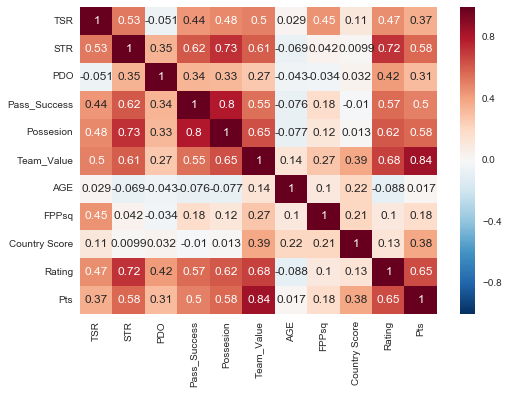

In [3]:
# 상관분석
# 0.3 ~ 0.7 선형관계를 보인다고 가정을 하고 기준을 0.5로 했을때
# TSR vs STR 
# Pass_Success vs Possesion
# Ratiing 과 all features
# Pts 포함

compare_feature = X.corr()
draw = sns.heatmap(compare_feature, annot = True)
plt.show(draw)

In [4]:
dfX0 = X[[x for x in [0,1,2,3,4,5,6,7,8,9]]]
dfy = X[['Pts']]
dfX0.head()
len(dfy) # 데이터 수

481

### 2. Preprocessing

In [5]:
# Scale
Scale_data = scale(dfX0)
dfX0

,TSR,STR,PDO,Pass_Success,Possesion,Team_Value,AGE,FPPsq,Country Score,Rating
0,0.628058,0.611384,1052.2580,0.800789,0.581842,11.00,25.0,0.666667,79.499,7.19
1,0.680405,0.720911,1035.7150,0.737797,0.615692,15.85,26.8,0.714286,79.499,7.30
2,0.629660,0.620096,1018.3460,0.809211,0.597632,6.24,21.7,0.688889,79.499,7.17
3,0.561334,0.567709,1026.9350,0.759474,0.522105,6.08,23.3,0.487805,79.499,7.19
4,0.606972,0.546114,1005.4350,0.777368,0.585789,11.22,24.4,0.800000,79.499,7.04
5,0.501111,0.560030,1049.4660,0.762105,0.641842,7.87,24.1,0.600000,79.499,7.06
6,0.532176,0.539966,1016.4290,0.748684,0.514737,5.28,23.1,0.547619,79.499,7.00
7,0.494795,0.503624,984.5211,0.631053,0.443947,2.58,25.3,0.828571,79.499,6.80
8,0.463708,0.430770,993.8975,0.735526,0.499211,2.21,25.3,0.642857,79.499,6.86
9,0.478690,0.441962,975.6079,0.631316,0.431316,2.67,25.3,0.562500,79.499,6.85


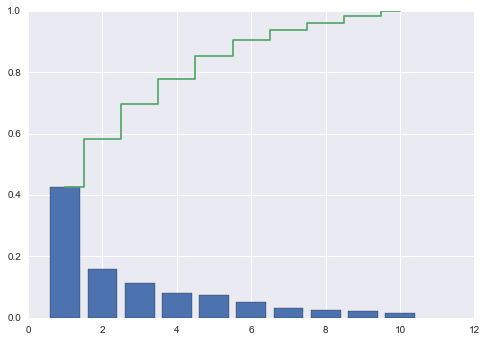

In [6]:
# PCA를 선택
# 독립변수로 쓸 변수들이 상관성이 높아서 각 변수들의 정보들을 최대한 이용하기 위해서 PCA를 사용
# 성분수의 결정
A = np.array(Scale_data) 
pca = PCA().fit(A)
var = pca.explained_variance_
cmap = sns.color_palette()
plt.bar(np.arange(1,len(var)+1), var/np.sum(var), align="center", color=cmap[0])
plt.step(np.arange(1,len(var)+1), np.cumsum(var)/np.sum(var), where="mid", color=cmap[1])
plt.show()
# PC5 까지 성분수 결정

In [7]:
# 성분수들의 결정계수들의 합 : 0.8이상이면 분석이 가능하다고 가정하에 진행
pca = PCA(n_components=5).fit(A)
k = (pca.explained_variance_ratio_) 
print (k[:5].sum())

0.851989243246


In [8]:
# PCA1 ~ 5 까지
pca.components_.T.shape
soccer_PCA_analysis = pd.DataFrame(pca.components_.T, columns = ["PC1", "PC2", "PC3", "PC4", "PC5"], index = dfX0.columns)
soccer_PCA_analysis

,PC1,PC2,PC3,PC4,PC5
TSR,-0.320913,-0.276918,0.444801,-0.079760,0.086319
STR,-0.411223,0.162802,0.016865,-0.144534,0.174635
PDO,-0.208648,0.294922,-0.517871,0.228252,-0.601846
Pass_Success,-0.394824,0.138201,0.096569,-0.117614,-0.151686
Possesion,-0.420964,0.145239,0.062862,-0.146547,0.028692
Team_Value,-0.400406,-0.214424,-0.176314,0.038025,0.177763
AGE,0.011769,-0.445354,-0.385594,-0.768908,-0.198709
FPPsq,-0.136733,-0.504761,0.351397,0.286494,-0.605112
Country Score,-0.087044,-0.511256,-0.450046,0.446360,0.349106
Rating,-0.405640,0.095683,-0.120872,0.106581,0.129930


### 3. Model

In [9]:
# PCA 분석으로 OLS Summary 
pca_s = PCA(5).fit_transform(A)
T_features = pd.DataFrame(pca_s, columns = ["PC1","PC2","PC3","PC4","PC5"])
regression = "dfy ~ PC1 + PC2 + PC3 + PC4 + PC5"
model = sm.OLS.from_formula(regression, data = T_features)
result = model.fit()

print (result.summary())
coef = np.array(result.params) # coef 만 출력

                            OLS Regression Results                            
Dep. Variable:                    dfy   R-squared:                       0.663
Model:                            OLS   Adj. R-squared:                  0.660
Method:                 Least Squares   F-statistic:                     187.1
Date:                Tue, 20 Dec 2016   Prob (F-statistic):          7.97e-110
Time:                        19:17:54   Log-Likelihood:                -2162.9
No. Observations:                 481   AIC:                             4338.
Df Residuals:                     475   BIC:                             4363.
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [95.0% Conf. Int.]
------------------------------------------------------------------------------
Intercept     51.1599      0.996     51.362      0.0

### 4. 레버리지 및 아웃라이어 분석

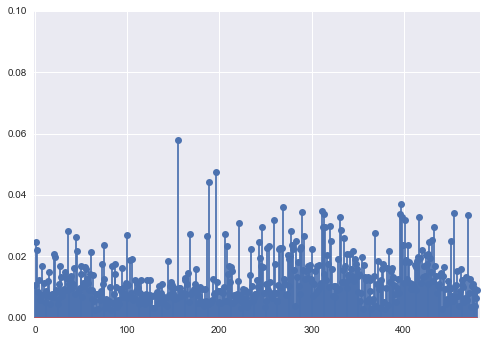

('hat.sum() =', 6.0)


In [10]:
# 레버리지와 아웃라이어 분석 
influence = result.get_influence()
hat = influence.hat_matrix_diag
plt.stem(hat)
plt.axis([-2, len(dfy)+2, 0, 0.1])
plt.show()
print("hat.sum() =", hat.sum())

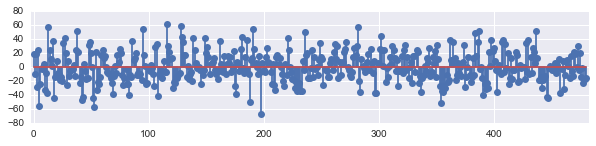

In [11]:
plt.figure(figsize=(10, 2))
plt.stem(result.resid)
plt.xlim([-2, len(dfy)+2])
plt.show()

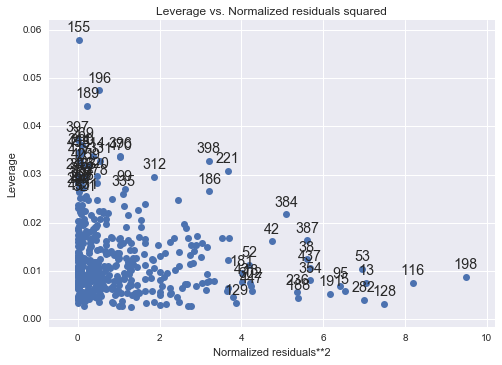

In [12]:
# Leverage와 잔차 상관관계 분석 결과
# - Good Leverage Point: *155
sm.graphics.plot_leverage_resid2(result)
plt.show()

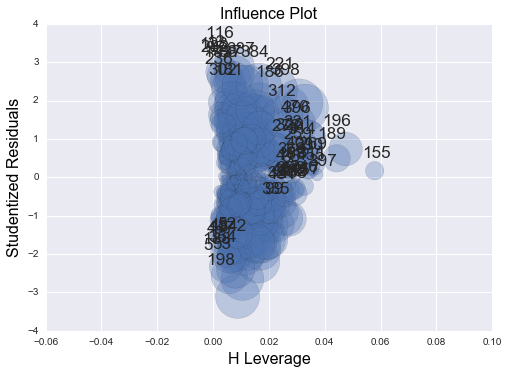

In [13]:
sm.graphics.influence_plot(result, plot_alpha=0.3)
plt.show()

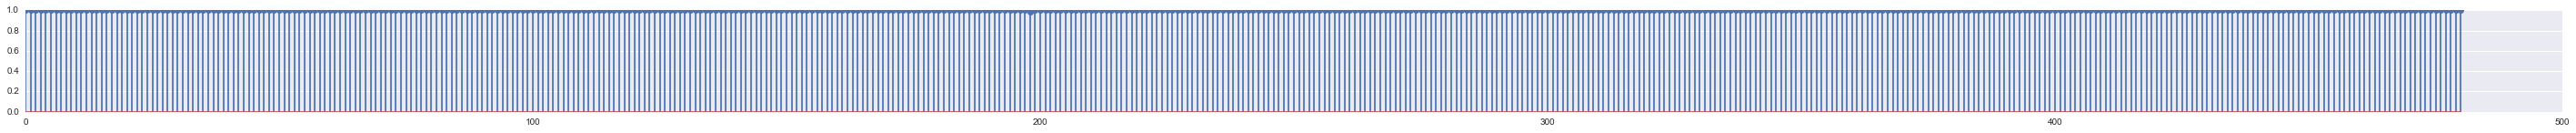

In [14]:
# 198
plt.figure(figsize=(50, 2))
plt.stem(result.outlier_test().ix[:, -1])
plt.show()

### 5. 모델평가

In [15]:
#Cross Validation Score : KFold로 진행
X = T_features.values
y = dfy.values.flatten()

model = LinearRegression()
cv2 = KFold(len(y), 3)
cross_val_score(model, X, y, "r2", cv2).mean()

/usr/local/lib/python2.7/site-packages/scipy/linalg/basic.py:884: RuntimeWarning: internal gelsd driver lwork query error, required iwork dimension not returned. This is likely the result of LAPACK bug 0038, fixed in LAPACK 3.2.2 (released July 21, 2010). Falling back to 'gelss' driver.
  warnings.warn(mesg, RuntimeWarning)


0.64170066915169643

### 6. 최종 성능평가

In [16]:
Test = pd.read_csv('./Resource/Test.csv') #EPL, Ligue 1, Bundesliga
Test.head()

,Season,NAT,Club_Name,TSR,STR,PDO,Pass_Success,Possesion,AGE,FPPsq,Team_Value,Country Score,Rating,Pts,Rank
0,1617,ENG,Manchester United,0.579077,0.552790,983.649439,0.835556,0.536667,26.7,0.666667,20.31,76.284,6.94,71.449,22
1,1617,ENG,Chelsea,0.646924,0.689434,1013.678451,0.846667,0.556667,26.9,0.769231,20.09,76.284,7.05,104.449,8
2,1617,ENG,Arsenal,0.564703,0.602590,1071.348650,0.845556,0.583333,26.5,0.724138,16.91,76.284,7.05,93.449,11
3,1617,ENG,Tottenham,0.633261,0.669257,1034.141830,0.811111,0.591111,25.2,0.652174,16.24,76.284,7.00,72.449,21
4,1617,ENG,Liverpool,0.654232,0.695990,964.987040,0.822500,0.593750,25.6,0.629630,14.01,76.284,6.97,54.449,29


In [17]:
Test_X = Test[[x for x in [3,4,5,6,7,8,9,10,11,12]]] #TSR ~ Rating까지 변수로 썼음.
Test_y = Test[['Pts']]

Test_X.head()

,TSR,STR,PDO,Pass_Success,Possesion,AGE,FPPsq,Team_Value,Country Score,Rating
0,0.579077,0.552790,983.649439,0.835556,0.536667,26.7,0.666667,20.31,76.284,6.94
1,0.646924,0.689434,1013.678451,0.846667,0.556667,26.9,0.769231,20.09,76.284,7.05
2,0.564703,0.602590,1071.348650,0.845556,0.583333,26.5,0.724138,16.91,76.284,7.05
3,0.633261,0.669257,1034.141830,0.811111,0.591111,25.2,0.652174,16.24,76.284,7.00
4,0.654232,0.695990,964.987040,0.822500,0.593750,25.6,0.629630,14.01,76.284,6.97


In [18]:
soccer_PCA_analysis # 모델에서 뽑은 PCA

,PC1,PC2,PC3,PC4,PC5
TSR,-0.320913,-0.276918,0.444801,-0.079760,0.086319
STR,-0.411223,0.162802,0.016865,-0.144534,0.174635
PDO,-0.208648,0.294922,-0.517871,0.228252,-0.601846
Pass_Success,-0.394824,0.138201,0.096569,-0.117614,-0.151686
Possesion,-0.420964,0.145239,0.062862,-0.146547,0.028692
Team_Value,-0.400406,-0.214424,-0.176314,0.038025,0.177763
AGE,0.011769,-0.445354,-0.385594,-0.768908,-0.198709
FPPsq,-0.136733,-0.504761,0.351397,0.286494,-0.605112
Country Score,-0.087044,-0.511256,-0.450046,0.446360,0.349106
Rating,-0.405640,0.095683,-0.120872,0.106581,0.129930


In [19]:
# 예측할 16/17 시즌들의 데이터와 PCA들의 행렬곱
convert_to_PCA = scale(Test_X).dot(np.array(soccer_PCA_analysis))
convert_to_PCA = sm.add_constant(convert_to_PCA)

In [20]:
# 모델에서의 coef 와 PCA의 성분들의 행렬곱
predict_to_PCA = convert_to_PCA.dot(coef)

In [21]:
# 예측한 Pts값과 실제 Pts의 값
predict = pd.DataFrame(data = predict_to_PCA, columns = ["Predict"])
result = pd.concat([Test.Club_Name ,Test.Pts, predict, Test.Rank], axis=1)

result.tail()

,Club_Name,Pts,Predict,Rank
28,Saint-Etienne,26.899,27.291905,62
29,Monaco,43.399,45.875392,40
30,Montpellier,15.399,1.255772,114
31,Guingamp,18.399,7.706425,97
32,Nice,10.399,48.863542,129


In [22]:
result.sort(['Predict'], ascending=[False] ) # Predict 기준으로 내림차순으로 정렬

/usr/local/lib/python2.7/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,Club_Name,Pts,Predict,Rank
5,Manchester City,87.449,93.682339,13
12,Bayern Munich,138.928,93.472754,2
1,Chelsea,104.449,92.380407,8
2,Arsenal,93.449,89.754672,11
3,Tottenham,72.449,88.989348,21
4,Liverpool,54.449,88.986281,29
6,Everton,27.449,83.017421,66
9,Southampton,17.949,79.750256,98
0,Manchester United,71.449,76.096027,22
26,Paris Saint,113.399,62.802957,6


### 7. 한계점

* 처음 기준으로 잡은 54개 리그 데이터를 크롤링하는데 제한이 있고 랭킹상에는 존재하지만 2부리그로 강등된 팀들의 데이터를 확보할 수가 없었다.
   + Whoscored 에는 주요리그 상세 데이터만을 제공
* 리그는 장기전인데 비해 유럽대회 단기전 성격이 강함
   + 단기전은 장기전인 리그에 비해 여러 변수에 의한 영향을 받는 정도가 더 크다. 
* 축구에는 다양한 전술, 다양한 변수 존재
   + 이 모든 것을 다 설명하기에는 기존의 분석에 쓰였던 독립변수로는 커버력이 부족하다는 것을 느꼈음
   
* 우리가 정한 변수들이 너무 공격력에 기반한 데이터를 수집하였다.

* 독립변수들이 데이터를 가공한 평균값으로 되어 있어서 아웃라이어를 제대로 파악하지 못했다.